In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from pylab import *
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


In [3]:
# give all parameter values that we will need later in script

gain = 1.7E6 #gain of chip

Rq = 150000 #ohm 
C = 91.0E-15 #farads
Rs = 16 #ohm 

e = 1.602E-19 #coulomb

In [7]:
# equations we will need later

T = Rq*C    # RC discharcing time constant
Q = gain*e  #this is spacing you need between peaks
tau = T/1E-9   #convert to ns 

print(T, tau, Q)

1.365e-08 13.649999999999999 2.7234e-13


In [8]:
# define function to create decaying RC waveform 
# amplitude depends on magnitude of incoming photon flux

def decay(time, Trc, amp=1):
    return(amp*np.exp(-time/Trc))

In [10]:
# want a 300ns windown with wave starting at 100ns

pulseLow =  np.zeros(100)
pulseHigh = np.ones(200)
newTimes = np.linspace(0, 300, 300)

pulseLength = np.append(pulseLow, pulseHigh)
pulse = pulseLength*decay(newTimes, tau)

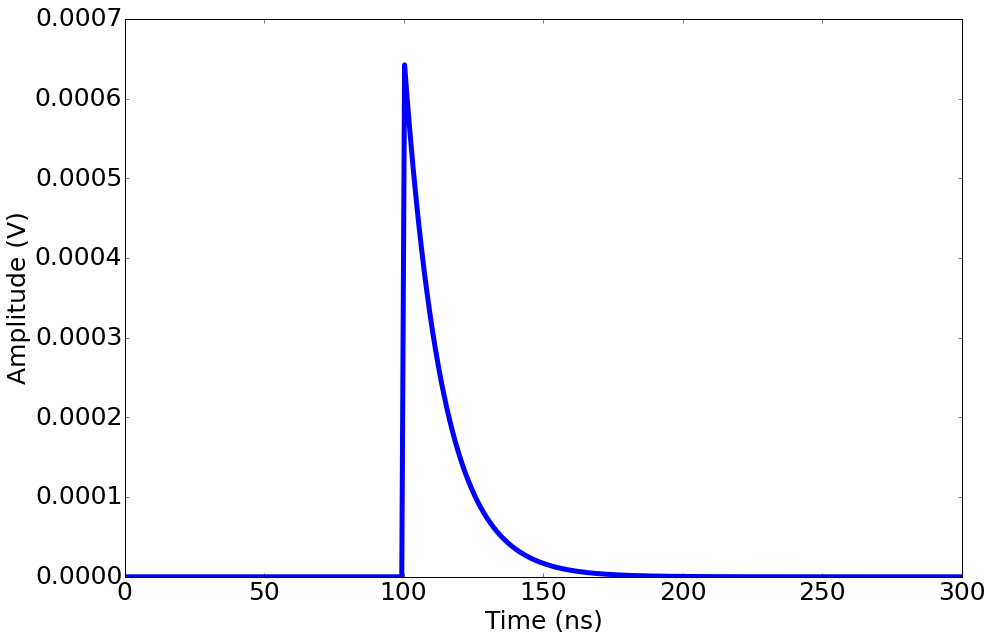

In [12]:
fig = figure(figsize=(15, 10))

plt.plot(newTimes, pulse, linewidth=5)
plt.xlabel("Time (ns)", fontsize=25)
plt.ylabel("Amplitude (V)", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

#plt.savefig('SimplifiedPulse.png')

In [33]:
PeakList = []
ChargeList = []

nPhoton = 100000
PDE = 0.40
truePhoton = nPhoton*PDE

#send in Poisson distributed waveforms 
wave = np.random.poisson(2, truePhoton)

#from Poisson distribution pick out the peak of each datapoint and integrate over time window to find charge
for i in range(wave.shape[0]):
    signal = pulseLength*(decay(newTimes, tau, wave[i]))+ np.random.normal(0, .00015, 300)
    PeakList.append(np.max(signal))
    ChargeList.append(signal[100:275].sum())

(array([-0.0005,  0.    ,  0.0005,  0.001 ,  0.0015,  0.002 ,  0.0025]),
 <a list of 7 Text yticklabel objects>)

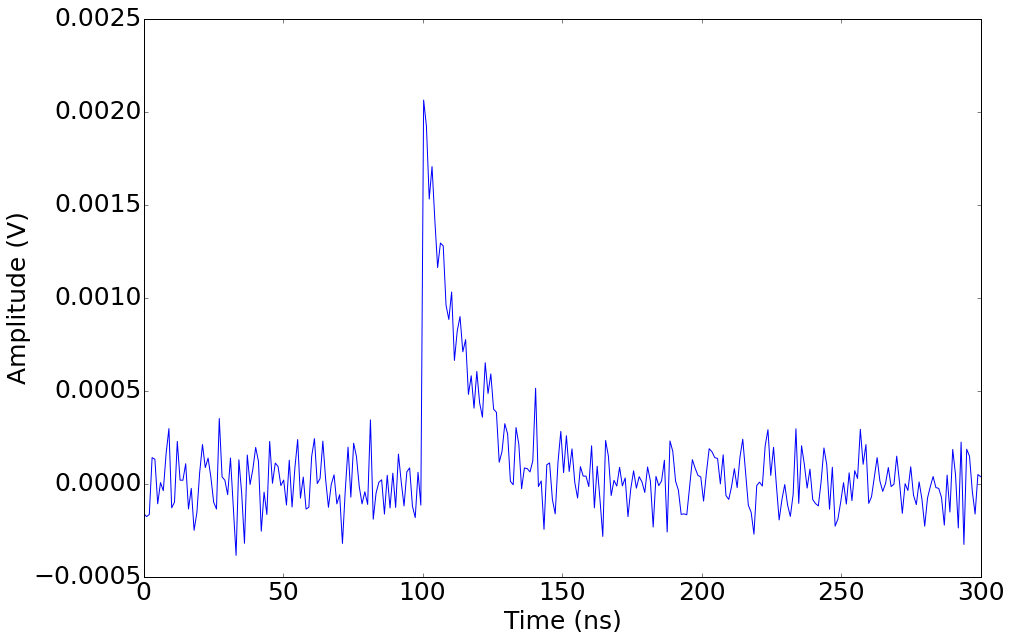

In [34]:
fig = figure(figsize(15,10))

plt.plot(newTimes, signal)
plt.xlabel("Time (ns)", fontsize=25)
plt.ylabel("Amplitude (V)", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

#plt.savefig('NoisyPulse.png')

(array([    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1400.]),
 <a list of 8 Text yticklabel objects>)

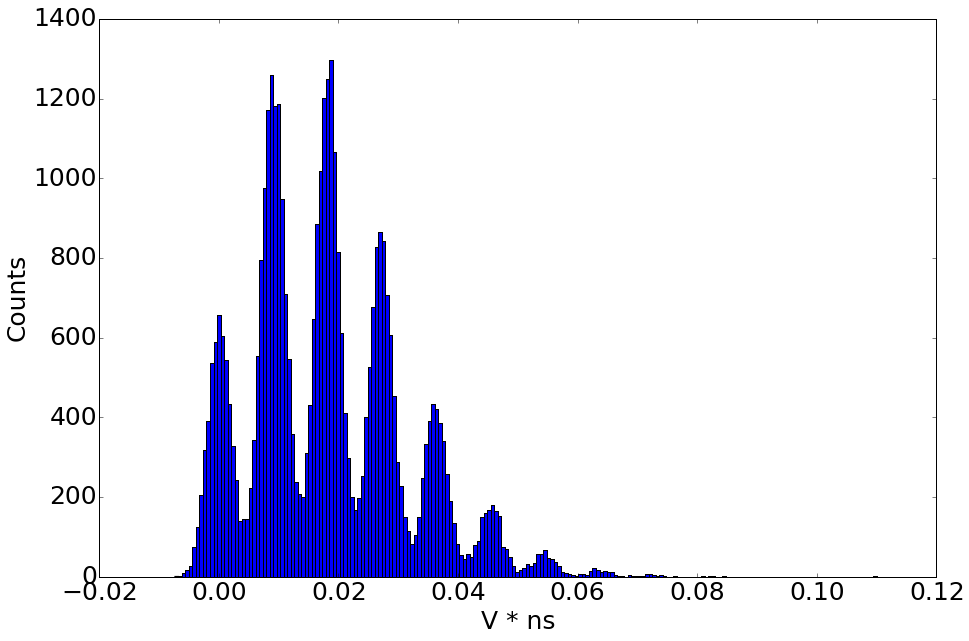

In [36]:
fig = plt.figure(figsize=(15,10))

plt.hist(ChargeList, 200)
plt.xlabel('V * ns', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

#plt.savefig('idealCharge.png')

[  2.43140321e-05   1.95804810e-03   6.37462402e+02   9.03714172e-03
   2.01745779e-03   1.25966622e+03   1.81644624e-02   1.98247055e-03
   1.26815924e+03   2.71010894e-02   1.96913188e-03   8.54644656e+02
   3.61541388e-02   1.99860747e-03   4.30590405e+02   4.53963317e-02
   1.99146716e-03   1.78422252e+02   5.43453049e-02   1.92621880e-03
   5.91681301e+01   6.34727888e-02   1.95230659e-03   1.61279496e+01] 
 [  2.59051922e-05   2.64021141e-05   7.27509146e+00   1.33917327e-05
   1.39241714e-05   7.20382859e+00   1.31958399e-05   1.37251083e-05
   7.26677688e+00   1.95150381e-05   2.02936562e-05   7.29080325e+00
   3.89215758e-05   4.02952286e-05   7.22999429e+00   9.37392737e-05
   9.70199430e-05   7.24261975e+00   2.77718081e-04   2.86347945e-04
   7.35653069e+00   1.01843394e-03   1.03147667e-03   7.27550002e+00]


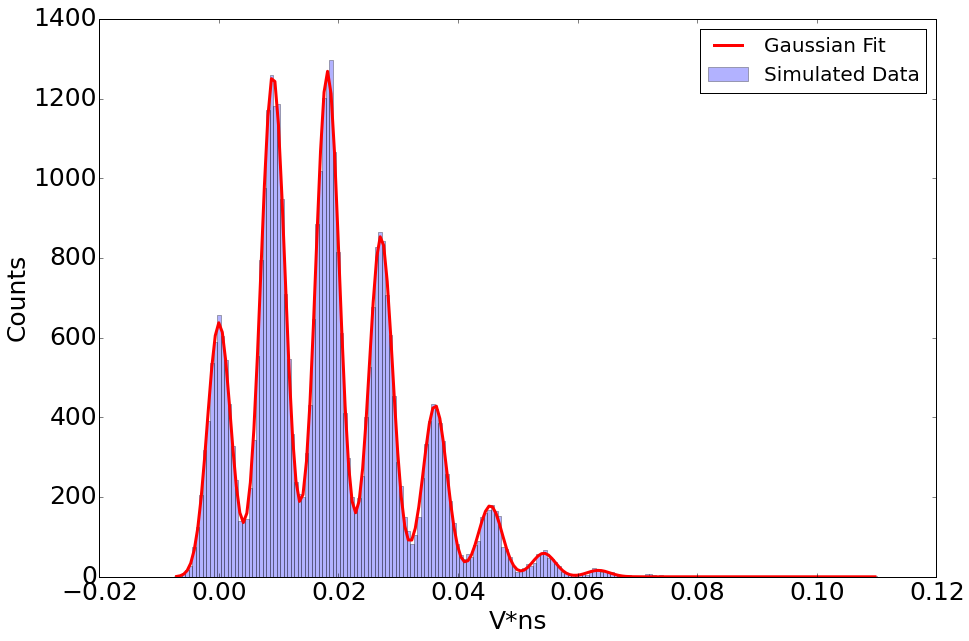

In [46]:
#now fit Gaussians to each of the peaks. Find amplitude, width, and mean value

fig = plt.figure(figsize=(15,10))

data1= ChargeList
y,x,_=hist(data1, 200, alpha=.3, label='Simulated Data')

x= (x[1:]+x[:-1])/2 # for len(x)==len(y)

def gaussian(x, mu, sig, amp):
    return(amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2, mu3,sigma3,A3, mu4,sigma4,A4, mu5,sigma5,A5, mu6,sigma6,A6, mu7,sigma7,A7, mu8,sigma8,A8):
    return gaussian(x,mu1,sigma1,A1)+gaussian(x,mu2,sigma2,A2)+gaussian(x,mu3,sigma3,A3)+gaussian(x,mu4,sigma4,A4)+gaussian(x,mu5,sigma5,A5)+gaussian(x,mu6,sigma6,A6)+gaussian(x,mu7,sigma7,A7)+gaussian(x,mu8,sigma8,A8)

#expected=(0.0,0.006, 1400.0, 0.001,0.005,2800.0, 0.019,0.005,2800.0, 0.028,0.005,1750.0, 0.0375,0.005,1000.0, 0.045,0.005,500.0, 0.055,0.007,100.0,0.062,0.0065,75.0)
expected=(0.0,0.006, 600.0, 0.001,0.005,1000.0, 0.019,0.005,1000.0, 0.028,0.005,650.0, 0.0375,0.005,375.0, 0.045,0.005,170.0, 0.055,0.007,75.0,0.062,0.0065,20.0)
params,cov=curve_fit(bimodal,x,y,expected)

sigma=sqrt(diag(cov))
plot(x,bimodal(x,*params),color='red',lw=3,label='Gaussian Fit')
legend(fontsize=20)
plt.xlabel('V*ns', fontsize=25)
plt.ylabel("Counts", fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
print(params,'\n',sigma)  

#plt.savefig('fit.png')

In [41]:
difList = []
peaks = params[0::3]

for i in range(0,7):
    dif = peaks[i+1]-peaks[i]
    difList.append(dif)
    
print(difList, mean(difList))

[0.009012827690055918, 0.0091273206702931226, 0.0089366269609395116, 0.0090530494847778989, 0.0092421928911757337, 0.0089489732051096713, 0.009127483895320844] 0.00906406782824


In [33]:
Q = (mean(difList)*(10**-9))/20.0
print(Q)

3.35809675745e-13


In [34]:
# gain
Q/1.602E-19

2096190.2356107172

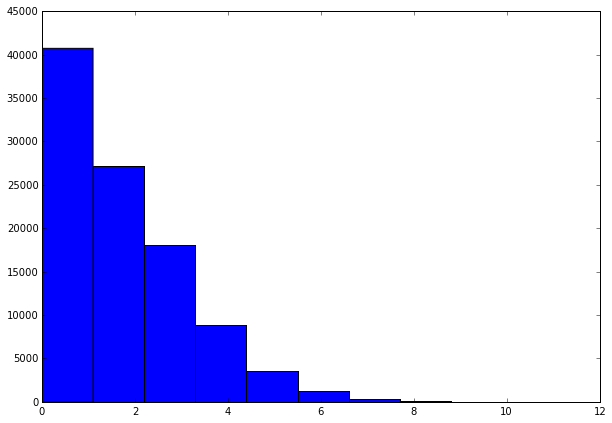

In [2]:
#reconstruct Poisson distribution with average 2pe
#plot histogram of distribution. As N-> infinity the distribution should look Gaussian 
#just shows visually what distribution is going to look like, doesn't really do anything at this point

s = np.random.poisson(2, 100000)

fig = plt.figure(figsize = (10,7))
plt.hist(s, 10)
plt.show()

In [3]:
#create function that produces a Gaussian 
# from CTA we know that 1pe corresponds to 8ADC counts so weight with that amplitude

def gaussian(x, mu, sig, amp=1):
    return(amp*(8.0)*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))

#plot(np.linspace(-10, 10, 1000), gaussian(np.linspace(-10, 10, 1000), 0, 4))

In [4]:
#create waveform that is 256ns/counts in length

signal = np.zeros(256)
times = np.linspace(0, 256, 256) #waveform is 256ns long in 1ns bins
peakList = []
chargeList = []

nPhoton = 100000
PDE = 0.52
truePhoton = nPhoton*PDE
#send in Poisson distributed waveforms 
s = np.random.poisson(2, truePhoton)

#from Poisson distribution pick out the peak of each datapoint and integrate over time window to find charge
for i in range(s.shape[0]):
    signal = (gaussian(times, 210, 5.0, s[i])) + np.random.normal(0, 5.0, 256)
    peakList.append(np.max(signal))
    chargeList.append(signal[205:215].sum())
#plt.plot(times, signal)

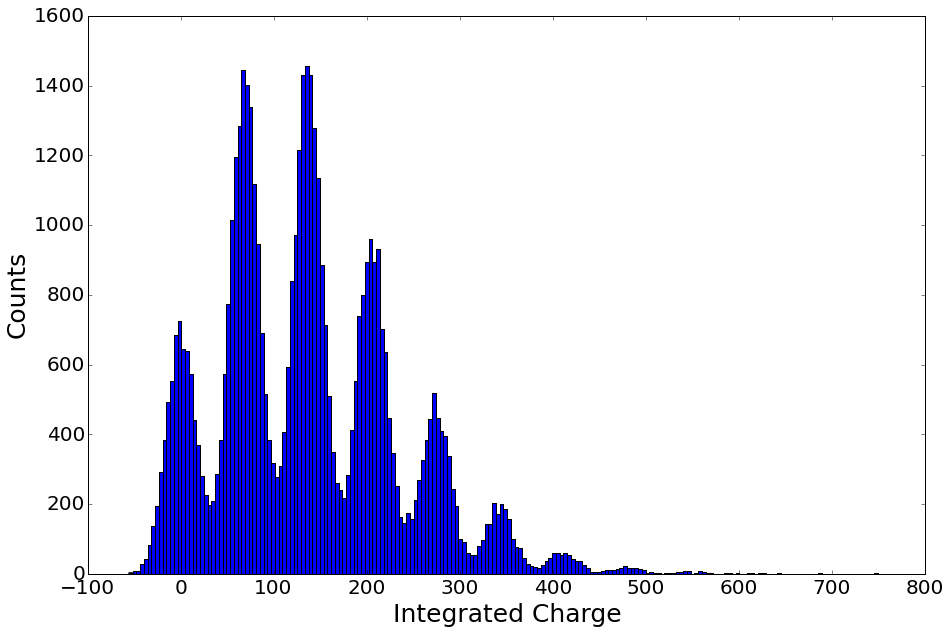

In [5]:
#when you plot the charge as a histogram then the peaks should form that represent the number of photoelectrons

fig = plt.figure(figsize=(15,10))

plt.hist(chargeList, 200)
plt.xlabel('Integrated Charge', fontsize=25)
plt.ylabel('Counts', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

[ -3.79526438e-02   1.61614288e+01   6.93863156e+02   6.84996770e+01
   1.57669537e+01   1.42504068e+03   1.36511946e+02   1.55320716e+01
   1.45391433e+03   2.04883739e+02   1.60015522e+01   9.53609058e+02
   2.73883800e+02   1.64521825e+01   4.71563486e+02   4.10014234e+02
   1.65295165e+01   6.04226272e+01   3.42238783e+02   1.46483644e+01
   1.95088547e+02   4.79972800e+02  -1.51655961e+01   2.00102018e+01] 
 [ 0.2052743   0.21219227  7.55490073  0.09997822  0.10673921  7.70609169
  0.09717088  0.10350241  7.75922116  0.1509817   0.16198901  7.6579134
  0.30855193  0.33055279  7.55448955  2.39831484  2.54837097  7.52475612
  0.70248305  0.74199728  7.96833772  6.86179118  7.02911736  7.77955019]


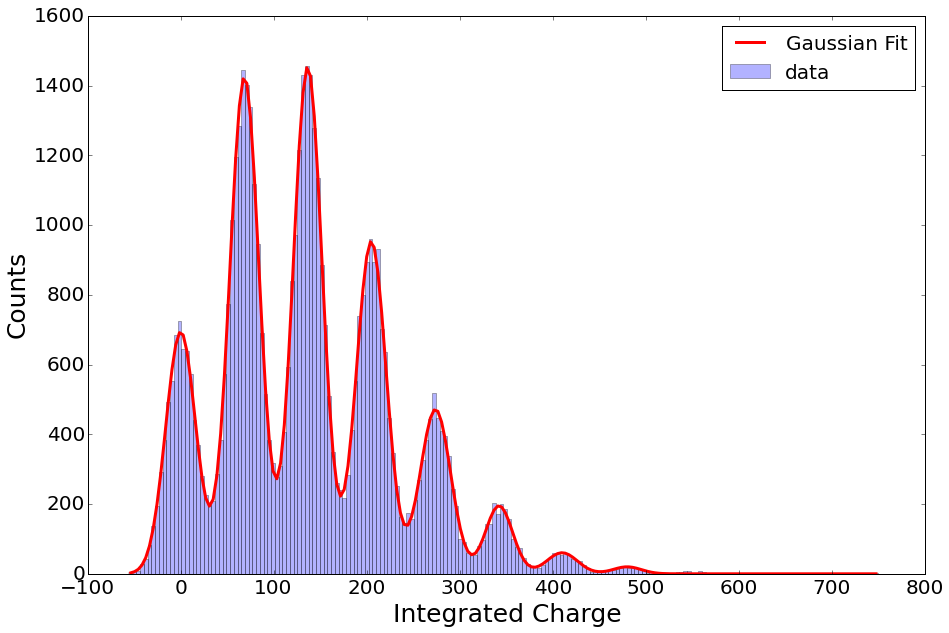

In [6]:
#now fit Gaussians to each of the peaks. Find amplitude, width, and mean value

fig = plt.figure(figsize=(15,10))

data= chargeList
y,x,_=hist(data, 200, alpha=.3, label='data')

x= (x[1:]+x[:-1])/2 # for len(x)==len(y)

expected=(0.0, 50.0 ,800.0,75.0, 50.0 ,1400.0, 130.0, 50.0 ,1400.0, 200.0, 50.0 ,1000.0, 275.0, 50.0 ,505.0, 350.0, 60.0 ,200.0, 405.0, 60.0, 100.0, 490.0, 55.0 ,22.0)
params,cov=curve_fit(bimodal,x,y,expected)

sigma=sqrt(diag(cov))
plot(x,bimodal(x,*params),color='red',lw=3,label='Gaussian Fit')
legend(fontsize=20)
plt.xlabel("Integrated Charge", fontsize=25)
plt.ylabel("Counts", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
print(params,'\n',sigma) 

#fig.save('testFig.png')

In [7]:
difList = []
peaks = params[0::3]

for i in range(0,7):
    dif = peaks[i+1]-peaks[i]
    difList.append(dif)
    
print(difList, mean(difList))

[68.537629619736677, 68.01226925651774, 68.371792728452732, 69.000060699403519, 136.13043392005648, -67.775450087353818, 137.73401639137256] 68.5729646469
